<a href="https://colab.research.google.com/github/LuigiPagani/ROM-with-POD-and-DL/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Original Systems
1. **Stokes' Equations:**
   The velocity $b$ and pressure $p$ of the water satisfy:
   $$
   \begin{cases}
   -\Delta b - \nabla p = w_1 f_1 + w_2 f_2 & \text{in } \Omega \\
   \nabla \cdot b = 0 & \text{in } \Omega \\
   b = 0 & \text{on } \partial \Omega
   \end{cases}
   $$
   Here, $f_1$ and $f_2$ represent the influence of two water turbines, and $w_1$ and $w_2$ are their respective strengths.

2. **Convection-Diffusion Equation:**
   The pollutant concentration $u$ satisfies:
   $$
   \begin{cases}
   -\Delta u + b \cdot \nabla u = 0 & \text{in } \Omega \times (0, T) \\
   -\nabla u \cdot n = 0 & \text{on } \partial \Omega \times (0, T) \\
   u(\cdot, 0) = u_0 & \text{in } \Omega
   \end{cases}
   $$

### Deduction of the Modified Equation
Given that $b_1$ and $b_2$ solve the Stokes' equation with $w_1 = 1, w_2 = 0$ and $w_1 = 0, w_2 = 1$ respectively, we can write the general solution $b$ as a linear combination of these basis solutions:
$$
b = w_1 b_1 + w_2 b_2
$$
where $b_1$ and $b_2$ are solutions to the Stokes' equations under the specified conditions.

Inserting this expression for $b$ into the convection-diffusion equation gives:
\[
-\Delta u + (w_1 b_1 + w_2 b_2) \cdot \nabla u = 0 \quad \text{in } \Omega \times (0, T)
\]
This simplifies to:
$$
\begin{cases}
-\Delta u + w_1 b_1 + w_2 b_2 \cdot \nabla u = 0 & \text{in } \Omega \times (0, T) \\
-\nabla u \cdot n = 0 & \text{on } \partial \Omega \times (0, T) \\
u(\cdot, 0) = u_0 & \text{in } \Omega
\end{cases}
$$
Thus, the equation (4) is derived, which allows us to focus solely on the convection-diffusion system by using the precomputed velocity fields $b_1$ and $b_1$ for the different strengths $w_1$ and $w_2$ of the turbines.

In practice, this approach simplifies the computational effort by decoupling the computation of the water's velocity and pressure fields from the pollutant's concentration simulation. Once $b_1$ and $b_2$ are computed, they can be scaled and summed according to $w_1$ and $w_2$ for any scenario, which can significantly reduce computational costs when simulating multiple scenarios with different turbine strengths.

### Equations:
The Stokes' equations are given by:
$$
-\Delta b - \nabla p = f
$$
$$
\nabla \cdot b = 0
$$
where $ f $ represents external forces (in this case, the forces due to the turbines).

### Solving with Specific Turbine Strengths:
1. **When $ w_1 = 1, w_2 = 0 $**:
   - The force term $ f $ in Stokes' equations becomes $ f_1 $.
   - Let $ b_1 $ and $ p_1 $ be the solutions, i.e.,:
     \begin{align*}
     -\Delta b_1 - \nabla p_1 = f_1
     \end{align*}
     \begin{align*}
     \nabla \cdot b_1 = 0
     \end{align*}




2. **When $ w_1 = 0, w_2 = 1 $**:
   - The force term $ f $ now becomes $ f_2 $.
   - Let $ b_2 $ and $ p_2 $ be the solutions, i.e.,:
     \begin{align*}
     -\Delta b_2 - \nabla p_2 = f_2
     \end{align*}
     \begin{align*}
     \nabla \cdot b_2 = 0
     \end{align*}

### Principle of Superposition:
Due to the linearity of the Stokes' equations, if $ b_1 $ and $ b_2 $ are solutions under the respective forces $ f_1 $ and $ f_2 $, any linear combination of these solutions is also a solution for a linear combination of the forces. Specifically:
$$
b = w_1 b_1 + w_2 b_2
$$

$$
-\Delta b - \nabla p = w_1 f_1 + w_2 f_2
$$
$$
\nabla \cdot b = 0
$$
Here, $ w_1 $ and $ w_2 $ act as scaling factors corresponding to the strength of each turbine's influence. This formulation essentially constructs the fluid flow's velocity field as a weighted sum of the two independent velocity fields induced by each turbine separately.


**Installation**

In [ ]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
!pip install pyDOE



  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=273ec6ec2258656d017645c4f32c4bb76d4946f2575f35bbb784a2d535a00151
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


**Preliminaries**

In [ ]:
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from convdiff import Stokes_solver
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)

def Convdiff_solver(w1, w2, steps = 50, dt = 5e-4):
    # Assembling relevant operators
    v1, v2 = TrialFunction(Vh), TestFunction(Vh)
    M = sp.csr_matrix(assemble(v1*v2*dx).array()) # mass matrix
    S = sp.csr_matrix(assemble(inner(grad(v1), grad(v2))*dx).array()) # stiffness (diffusion) matrix

    b = Stokes_solver(w1, w2)
    b1 = Stokes_solver(1,0)
    b2 = Stokes_solver(0,1)
    bf = fe.asvector(b, bspace)
    bf1 = fe.asvector(b1, bspace)
    bf2 = fe.asvector(b2, bspace)

    B  = sp.csr_matrix(assemble(inner(bf, grad(v1))*v2*dx).array()) # transport matrix
    B1 = sp.csr_matrix(assemble(inner(bf1, grad(v1))*v2*dx).array())
    B2 = sp.csr_matrix(assemble(inner(bf2, grad(v1))*v2*dx).array())

    # Time-stepping scheme
    def FOMstep(u0, dt, b):
        A = M + dt*S + 1000*dt*B
        F = M @ u0
        return spsolve(A, F)

    # Initial condition
    x, y = fe.coordinates(Vh).T
    u0 = np.exp(-16*(x-0.5)**2 -16*(y-0.5)**2)

    # Initialize storage for solution as a NumPy array
    u = np.empty((len(u0), steps + 1))
    u[:, 0] = u0

    # Time loop
    for n in range(steps):
        u[:, n + 1] = FOMstep(u[:, n], dt, b)

    return u, M, S, B, B1, B2


# Define the parameter space
n_samples = 1000  # Reduced number of samples
parameter_ranges = [np.linspace(0, 1000, 1000), np.linspace(0, 1000, 1000)]  # Define parameter ranges

# Generate Latin Hypercube Samples
lhs_samples = lhs(2, samples=n_samples, criterion='center')  # 2 for two parameters, criterion 'center' for centered samples
params = np.array([parameter_ranges[0][((lhs_samples[:, i] * 99).astype(int))] for i in range(2)]).T

# Generate snapshots
snapshots = []  # Initialize an empty list to store matrices
for w1, w2 in params:
    u, M, S, B,B1,B2 = Convdiff_solver(w1, w2)  # Get the time series data and matrices from the solver
    u = u.reshape(961, -1)  # Reshape u to have consistent dimensions
    if len(snapshots) == 0:
        snapshots = u  # If snapshots is empty, initialize it with the first u
    else:
        snapshots = np.hstack((snapshots, u))  # Stack u horizontally with the existing snapshots




In [ ]:
np.save('/content/snapshots_1000.npy', snapshots)


**Singular Value Study**

**Matrix Assembly**

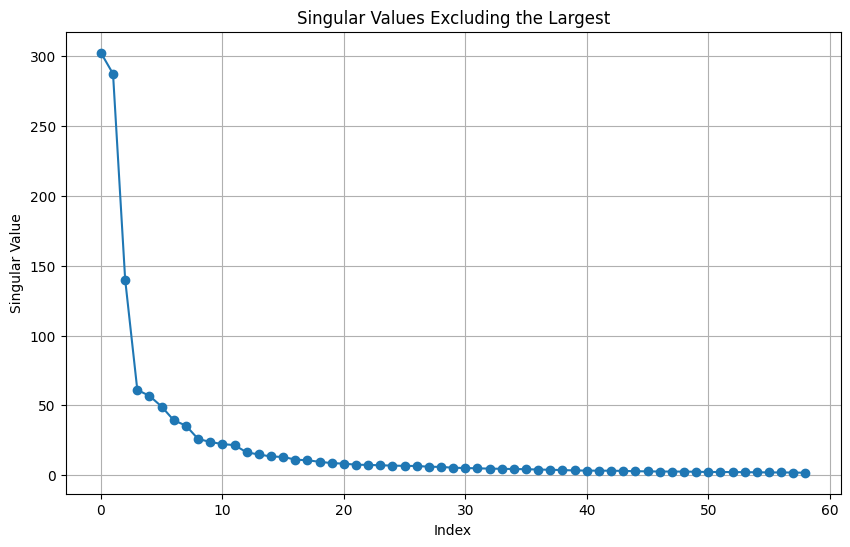

In [ ]:
from scipy.linalg import svd
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from convdiff import Stokes_solver
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

#snapshots = np.load('/content/snapshots.npy')


U, s, Vt = svd(snapshots, full_matrices=False)


# Now you can apply SVD or any other analysis you wish to this giant matrix
from scipy.linalg import svd
U, s, Vt = svd(snapshots, full_matrices=False)

energy = np.cumsum(s**2) / np.sum(s**2)

# Determine number of modes to retain 99% of energy
n_modes = 35

V = U[:, :n_modes]

import matplotlib.pyplot as plt
import numpy as np

# Assuming 's' contains your singular values from the SVD
singular_values = s[1:60]  # Exclude the largest singular value

# Plotting the remaining singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, marker='o')
plt.title('Singular Values Excluding the Largest')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()




mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)

from scipy.sparse import csr_matrix

# Assuming we have a function to assemble FOM matrices
w1 = 5
w2 = 5
u, M_fom, S_fom, B_fom,B1_fom,B2_fom = Convdiff_solver(w1, w2, steps = 50, dt = 5e-4)

M_rb = V.T @ M_fom @ V
S_rb = V.T @ S_fom @ V
B_rb = V.T @ B_fom @ V
B1_rb = V.T @ B1_fom @ V
B2_rb = V.T @ B2_fom @ V





**Time Stepping**



In [ ]:
w1 = 900
w2 = 100
u, M_fom, S_fom, B_fom,B1_fom,B2_fom = Convdiff_solver(w1, w2, steps = 50, dt = 5e-4)
def RBstep(u_rb, dt,w1,w2):
    # Assuming M_rb, S_rb, B1_rb, B2_rb, w1, w2 are defined elsewhere and are numpy arrays
    A_rb = M_rb + dt * S_rb + 1000 * dt * (w1 * B1_rb + w2 * B2_rb)
    F_rb = M_rb @ u_rb
    return np.linalg.solve(A_rb, F_rb)

# Assuming 'V' is the matrix containing the left singular vectors (reduced basis vectors)
# and 'u' contains the simulation snapshots from the Full Order Model (FOM).

u0_rb = V.T @ u[:,0]  # Project the initial condition onto the reduced basis

# Number of time steps based on final time T and time step dt
T_final = 0.025
dt = 5e-4
n_steps = int(T_final / dt)

# Initialize storage for RB solution as a NumPy array
u_rb = np.zeros((V.shape[1], n_steps + 1))  # V.shape[1] is the number of reduced basis vectors
u_rb[:, 0] = u0_rb

# Time-stepping loop for the RB method
for n in range(n_steps):
    u_rb[:, n + 1] = RBstep(u_rb[:, n], dt,w1,w2)

# Optionally, convert back to full space for visualization or further analysis
u_rb_full = V @ u_rb  # This results in each column representing the solution at a time step

# If you need to transpose for further processing:

# Assuming 'u' is the original full matrix, and 'u_rb_full' is the reconstructed matrix after reduction and back-projection

error_vector = u - u_rb_full

# Calculate the norm of the difference (numerator of the relative error)
error_norm = np.linalg.norm(error_vector, axis=0)  # Since we transposed, use axis=0 to operate along columns

# Calculate the norm of the original vector (denominator of the relative error)
u_norm = np.linalg.norm(u, axis=0)  # Norm of each column in the original matrix

# Calculate the relative error for each column
relative_error = error_norm / u_norm

# Calculate the average of the relative errors
average_relative_error = np.mean(relative_error)

print("Average Relative Error:", average_relative_error)

Average Relative Error: 0.23716621972560917


In [ ]:
u.shape

(100, 51)

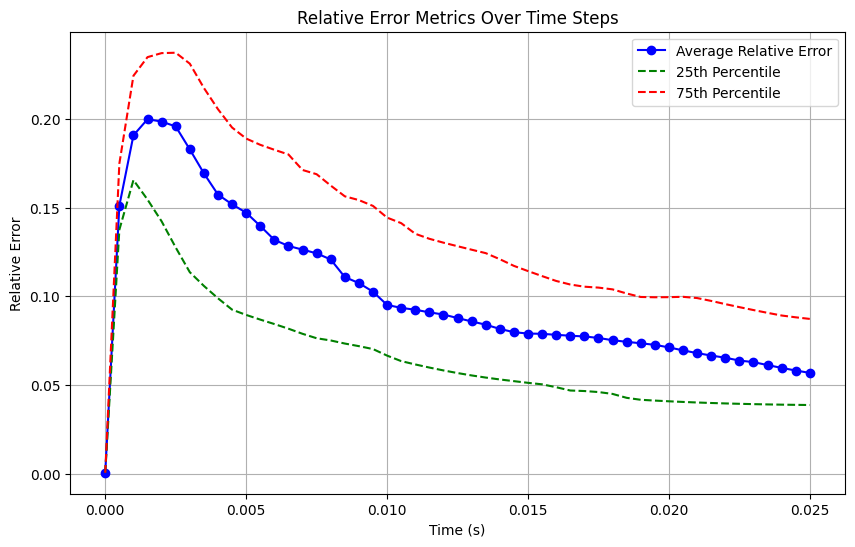

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the problem dimensions and parameters
n_tests = 50
T_final = 0.025
dt = 5e-4
n_steps = int(T_final / dt)
weights_range = (300, 700)

# Initialize the storage for errors
errors = np.zeros((n_tests, n_steps + 1))

# Loop over each test case
for test in range(n_tests):
    # Randomly sample weights w1 and w2
    w1 = np.random.uniform(*weights_range)
    w2 = np.random.uniform(*weights_range)

    # Generate the system matrices for RB using the Convdiff_solver (assuming it's implemented)
    u, a, b, c, d,e = Convdiff_solver(w1, w2, steps=50, dt=dt)

    # Initial condition projection
    u0_rb = V.T @ u[:,0]

    # Initialize storage for RB solution
    u_rb[:, 0] = u0_rb

    # Time-stepping loop for the RB method
    for n in range(n_steps):
        u_rb[:, n + 1] = RBstep(u_rb[:, n], dt, w1, w2)

    # Convert back to full space and compute error
    u_rb_full = V @ u_rb
    error_vector = u - u_rb_full
    error_norm = np.linalg.norm(error_vector, axis=0)
    u_norm = np.linalg.norm(u, axis=0)
    relative_error = error_norm / u_norm

    # Store the error for this test
    errors[test, :] = relative_error

# Calculate the average, 25th and 75th percentiles of the relative errors across all tests
average_relative_error = np.median(errors, axis=0)
percentile_25 = np.percentile(errors, 25, axis=0)
percentile_75 = np.percentile(errors, 75, axis=0)

# Plotting the average relative error and quantiles over time steps
plt.figure(figsize=(10, 6))
times = np.linspace(0, T_final, n_steps + 1)
plt.plot(times, average_relative_error, label='Average Relative Error', marker='o', color='blue')
plt.plot(times, percentile_25, label='25th Percentile', linestyle='--', color='green')
plt.plot(times, percentile_75, label='75th Percentile', linestyle='--', color='red')

plt.title('Relative Error Metrics Over Time Steps')
plt.xlabel('Time (s)')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
errors.shape

(50, 51)